In [1]:
import gym
import minihack
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import time

from SearchAlgo.utils import *
from SearchAlgo.algorithms import *

In [ ]:
#Create our environment specifying the Map and what keys we have to observe
env = gym.make("MiniHack-ExploreMaze-Hard-Mapped-v0", observation_keys=("chars", "pixel", "blstats", "message"))
state = env.reset()

coordinates = [500, 500]

plt.imshow(state['pixel'][:coordinates[0], :coordinates[1]])

game_map = state['chars']
game = state['pixel']
game_stats = state['blstats']
game_mex = state['message']

#game_map = np.array(game_map)

def format_path(coord_input):
    # Se è una singola coordinata
    if isinstance(coord_input, tuple) or (isinstance(coord_input, np.ndarray) and coord_input.ndim == 1):
        return (int(coord_input[0]), int(coord_input[1]))
    # Se è una lista/array di coordinate
    return [(int(x), int(y)) for x, y in coord_input]

start = get_player_location(game_map)
target = get_target_location(game_map)
hp = game_stats[6]
monsters = get_monster_positions(game_map)

print("Monster positions:", format_path(monsters))
print("Agent position:", format_path(start))
print("Target position:", format_path(target))


# Add Game Over function
def display_game_over():
    plt.text(0.5, 0.5, "Game Over: You were killed by monsters!",
             fontsize=20, ha='center', va='center', color='red', transform=plt.gca().transAxes)

# Add ictory function
def display_victory():
    plt.text(0.5, 0.5, "Victory: You reached the target!",
             fontsize=20, ha='center', va='center', color='green', transform=plt.gca().transAxes)

# Funzione per separare gli algoritmi in informati e non informati
def classify_algorithms():
    uninformed_algorithms = {
        "BFS": bfs,
        "DFS": dfs
    }
    informed_algorithms = {
        "Greedy": greedy,
        "A*": a_star_with_monsters,
        "Beam": beam_search,
        "Theta*": theta_star
    }
    return uninformed_algorithms, informed_algorithms

def evaluate_algorithm(algorithm, game_map, start, target, distance_function=None, **kwargs):
    start_time = time.time()

    try:
        if distance_function:
            path = algorithm(game_map, start, target, distance_function, **kwargs)
        else:
            path = algorithm(game_map, start, target, **kwargs)
    except Exception as e:
        return {"error": str(e)}

    end_time = time.time()
    execution_time = end_time - start_time

    # Calcola metriche
    path_length = len(path) if path else float('inf')  # Lunghezza del percorso trovata
    success = path[-1] == target if path else False   # Verifica se raggiunge il target

    return {
        "success": success,
        "path_length": path_length,
        "execution_time": execution_time
    }

def pretty_print_results(label, results):
    print(f"{label} Results:")
    for key, value in results.items():
        print(f"  {key}: {value}")

def get_best_algorithm(results):
    successful_results = [
        result for result in results if 'success' in result[1] and result[1]['success']
    ]
    if successful_results:
        return min(successful_results, key=lambda x: (x[1]['path_length'], x[1]['execution_time']))
    return None

# Esegui gli algoritmi per ciascuna categoria e misura il tempo di esecuzione
results_uninformed = [
    ("BFS", evaluate_algorithm(bfs, game_map, start, target)),
    ("DFS", evaluate_algorithm(dfs, game_map, start, target))
]
results_informed = [
    ("Greedy", evaluate_algorithm(greedy, game_map, start, target, h=manhattan_distance)),
    ("A*", evaluate_algorithm(a_star_with_monsters, game_map, start, target, h=manhattan_distance, monsters=[])),
    ("Theta*", evaluate_algorithm(a_star_with_monsters, game_map, start, target, h=euclidean_distance)),
    ("Beam", evaluate_algorithm(beam_search, game_map, start, target, h=manhattan_distance, beam_width=5))
]

# Trova il miglior algoritmo per ciascuna categoria
best_uninformed = get_best_algorithm(results_uninformed)
best_informed = get_best_algorithm(results_informed)

path = theta_star(game_map, start, target, euclidean_distance)

def visualize_maze_step(game_image, coordinates, pause_time=0.1):
    """
    Visualizza un singolo frame del maze con aggiornamento in tempo reale

    Args:
        game_image: L'immagine del gioco da visualizzare
        coordinates: Le coordinate per il cropping dell'immagine
        pause_time: Tempo di pausa tra i frame in secondi
    """
    plt.clf()  # Pulisce la figura corrente
    plt.imshow(game_image[:coordinates[0], :coordinates[1]])
    plt.draw()  # Aggiorna il plot
    plt.pause(pause_time)  # Pausa per permettere l'aggiornamento della visualizzazione

if path is None:
    print("No valid path found. Algorithm failed to reach the target.")
else:
    actions = actions_from_path(start, path[1:])

    # Crea una finestra di visualizzazione
    plt.figure(figsize=(10, 10))
    plt.ion()  # Abilita la modalità interattiva

    image = plt.imshow(game[:coordinates[0], :coordinates[1]])
    for action in actions:
        s, _, done, _ = env.step(action)  # `done` say to us when the simulation is over
        image.set_data(s['pixel'][:coordinates[0], :coordinates[1]])
        game_stats = state['blstats']  # Aggiorna statistiche
        hp = game_stats[6]  # Aggiorna hp

        # If the simulation is done
        if done:
            # If player's hp are equal to 0 it means that he is dead
            if hp == 0:
                display_game_over()
                break  # Interrupt the smulation

            # Else you have won
            display_victory()
            break  # Interrupt the smulation

        # Update the game visualization
        #display.display(plt.gcf())
        #display.clear_output(wait=True)

Monster positions: []
Agent position: (7, 1)
Target position: (5, 14)
Target found!
Target found!
Target found!
Target found!
Target found!


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

def run_algorithm_comparison(num_seeds):
    # Dictionaries to store results for each seed
    time_results = defaultdict(list)
    path_results = defaultdict(list)

    for seed in range(num_seeds):
        # Reset environment with new seed
        env = gym.make("MiniHack-ExploreMaze-Hard-Mapped-v0",
                       observation_keys=("chars", "pixel", "blstats", "message"))
        # Set the seed correctly
        env.seed(seed)
        state = env.reset()  # Now reset without seed parameter

        game_map = state['chars']
        start = get_player_location(game_map)
        target = get_target_location(game_map)

        # Run uninformed algorithms
        uninformed_algos= {
            "BFS": bfs,
            "DFS": dfs
        }

        # Run informed algorithms
        informed_algos= {
            "Greedy": lambda x, y, z: greedy(x, y, z, manhattan_distance),
            "A*": lambda x, y, z: a_star(x, y, z, manhattan_distance),
            "Theta*": lambda x, y, z: theta_star(x, y, z, manhattan_distance),
            "Beam": lambda x, y, z: beam_search(x, y, z, manhattan_distance, beam_width=5)
        }

        # Combine all algorithms
        all_algorithms = {**uninformed_algos, **informed_algos}

        # Evaluate each algorithm
        for algo_name, algo_func in all_algorithms.items():
            result = evaluate_algorithm(algo_func, game_map, start, target)
            print(f"Seed: {seed}, algo_name {algo_name} :  {result}")

            if result.get('success', False):
                time_results[algo_name].append(result['execution_time'])
                path_results[algo_name].append(result['path_length'])

    return time_results, path_results, uninformed_algos.keys(), informed_algos.keys()

def calculate_averages(results, algo_names):
    averages = {}
    for algo in algo_names:
        if algo in results and results[algo]:
            averages[algo] = np.mean(results[algo])
    return averages

def calculate_best_percentages(results):
    total_seeds = len(next(iter(results.values())))
    best_counts = defaultdict(int)

    for i in range(total_seeds):
        best_algo = min(results.keys(),
                        key=lambda k: results[k][i] if i <= len(results[k]) else float('inf'))
        best_counts[best_algo] += 1

    percentages = {algo: (count / total_seeds) * 100
                   for algo, count in best_counts.items()}
    return percentages

def plot_combined_results(time_results, path_results, uninformed_algos, informed_algos):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Calculate averages
    uninformed_time_avg = calculate_averages(time_results, uninformed_algos)
    informed_time_avg = calculate_averages(time_results, informed_algos)
    uninformed_path_avg = calculate_averages(path_results, uninformed_algos)
    informed_path_avg = calculate_averages(path_results, informed_algos)

    # Combine all algorithms while preserving type information
    all_algos = []
    colors = []
    time_values = []
    path_values = []

    # Add uninformed algorithms
    for algo in uninformed_time_avg.keys():
        all_algos.append(algo)
        colors.append('skyblue')
        time_values.append(uninformed_time_avg[algo])
        path_values.append(uninformed_path_avg[algo])

    # Add informed algorithms
    for algo in informed_time_avg.keys():
        all_algos.append(algo)
        colors.append('lightcoral')
        time_values.append(informed_time_avg[algo])
        path_values.append(informed_path_avg[algo])

    # Plot average execution times
    bars1 = ax1.bar(range(len(all_algos)), time_values, color=colors)
    ax1.set_title('Average Execution Time by Algorithm Type')
    ax1.set_xlabel('Algorithms')
    ax1.set_ylabel('Time (seconds)')
    ax1.set_xticks(range(len(all_algos)))
    ax1.set_xticklabels(all_algos, rotation=45)

    # Add average time values above bars
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{time_values[i]:.4f}s',
                 ha='center', va='bottom')

    # Plot average path lengths
    bars2 = ax2.bar(range(len(all_algos)), path_values, color=colors)
    ax2.set_title('Average Path Length by Algorithm Type')
    ax2.set_xlabel('Algorithms')
    ax2.set_ylabel('Number of Steps')
    ax2.set_xticks(range(len(all_algos)))
    ax2.set_xticklabels(all_algos, rotation=45)

    # Add average path length values above bars
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{path_values[i]:.1f}',
                 ha='center', va='bottom')

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='skyblue', label='Uninformed'),
        Patch(facecolor='lightcoral', label='Informed')
    ]
    ax1.legend(handles=legend_elements)
    ax2.legend(handles=legend_elements)

    plt.tight_layout()
    return fig, {
        'all_algorithms': all_algos,
        'execution_times': time_values,
        'path_lengths': path_values
    }

# Run the comparison
print("Running algorithm comparison...")
time_results, path_results, uninformed_algos, informed_algos = run_algorithm_comparison(5)

# Create and display the plots
fig, results = plot_combined_results(time_results, path_results, uninformed_algos, informed_algos)
plt.show()

# Print detailed statistics
print("\nDetailed Average Statistics:")
print("\nBy Algorithm Type:")
for i, algo in enumerate(results['all_algorithms']):
    print(f"\n{algo}:")
    print(f"Average Execution Time: {results['execution_times'][i]:.4f} seconds")
    print(f"Average Path Length: {results['path_lengths'][i]:.1f} steps")

Running algorithm comparison...
Target found!
Seed: 0, algo_name BFS :  {'success': True, 'path_length': 17, 'execution_time': 0.0010447502136230469}
Target found!
Seed: 0, algo_name DFS :  {'success': True, 'path_length': 705, 'execution_time': 0.0035703182220458984}
Target found!
Seed: 0, algo_name Greedy :  {'success': True, 'path_length': 17, 'execution_time': 0.0002739429473876953}
Target found!
Seed: 0, algo_name A* :  {'success': True, 'path_length': 17, 'execution_time': 0.00023126602172851562}


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fc572549d90>>
Traceback (most recent call last):
  File "/home/kcardona/miniconda3/envs/minicondaenv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML

def visualize_graph_exploration(game_map, algorithm, start, target, delay=200, **kwargs):
    """
    Creates an animated visualization of how a graph algorithm explores the maze.

    Args:
        game_map: The game map array
        algorithm: The pathfinding algorithm function to visualize
        start: Starting position
        target: Target position
        delay: Delay between frames in milliseconds
        **kwargs: Additional arguments for the algorithm
    """
    # Store exploration history during algorithm execution
    exploration_history = []

    # Wrapper for the algorithm to capture exploration steps
    def exploration_callback(current_node, visited, frontier):
        exploration_history.append({
            'current': current_node,
            'visited': visited.copy(),
            'frontier': frontier.copy() if hasattr(frontier, 'copy') else list(frontier)
        })

    # Modify the algorithm to use the callback
    kwargs['exploration_callback'] = exploration_callback
    final_path = algorithm(game_map, start, target, **kwargs)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))

    def init():
        ax.clear()
        # Draw the base maze
        maze_img = np.zeros((game_map.shape[0], game_map.shape[1], 3))
        maze_img[game_map == ord('.')] = [1, 1, 1]  # Floor
        maze_img[game_map == ord('#')] = [0.2, 0.2, 0.2]  # Walls
        ax.imshow(maze_img)
        return [ax]

    def animate(frame):
        ax.clear()
        # Draw base maze
        maze_img = np.zeros((game_map.shape[0], game_map.shape[1], 3))
        maze_img[game_map == ord('.')] = [1, 1, 1]  # Floor
        maze_img[game_map == ord('#')] = [0.2, 0.2, 0.2]  # Walls

        if frame < len(exploration_history):
            step = exploration_history[frame]

            # Color visited nodes
            for node in step['visited']:
                maze_img[node[0], node[1]] = [0.7, 0.9, 0.7]  # Light green

            # Color frontier nodes
            for node in step['frontier']:
                if isinstance(node, tuple):
                    node_pos = node
                else:  # Handle A* nodes that might contain additional info
                    node_pos = node[0] if isinstance(node[0], tuple) else node
                maze_img[node_pos[0], node_pos[1]] = [0.9, 0.7, 0.7]  # Light red

            # Color current node
            if step['current']:
                maze_img[step['current'][0], step['current'][1]] = [0, 0.8, 0]  # Bright green

        # Always show start and target
        maze_img[start[0], start[1]] = [0, 0, 1]  # Blue for start
        maze_img[target[0], target[1]] = [1, 0, 0]  # Red for target

        # If we're at the last frame and have a final path, show it
        if frame == len(exploration_history) - 1 and final_path:
            for node in final_path:
                maze_img[node[0], node[1]] = [1, 1, 0]  # Yellow for final path

        ax.imshow(maze_img)
        ax.set_title(f'Step {frame + 1}/{len(exploration_history)}')
        return [ax]

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(exploration_history),
                                   interval=delay, blit=True)

    plt.close()  # Prevent display of static plot
    return HTML(anim.to_jshtml())

# Modified algorithm example (BFS) to support visualization
def bfs_with_visualization(game_map, start, target, exploration_callback=None):
    from collections import deque

    frontier = deque([start])
    visited = set()
    came_from = {start: None}

    while frontier:
        current = frontier.popleft()

        if exploration_callback:
            exploration_callback(current, visited, frontier)

        if current == target:
            # Reconstruct path
            path = []
            while current:
                path.append(current)
                current = came_from[current]
            return path[::-1]

        visited.add(current)

        # Get valid neighbors
        for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            next_pos = (current[0] + dx, current[1] + dy)

            if (next_pos not in visited and
                    0 <= next_pos[0] < game_map.shape[0] and
                    0 <= next_pos[1] < game_map.shape[1] and
                    game_map[next_pos] != ord('#')):

                frontier.append(next_pos)
                if next_pos not in came_from:
                    came_from[next_pos] = current

    return None

# Example usage
animation = visualize_graph_exploration(game_map, bfs_with_visualization, start, target, delay=200)
display(animation)

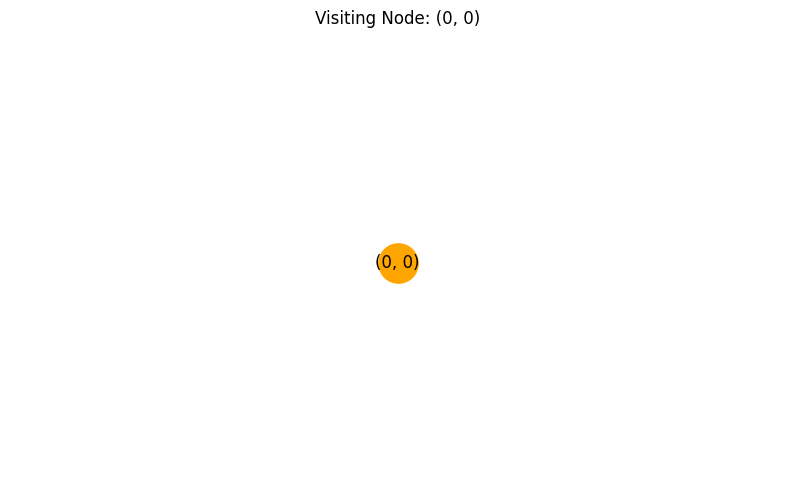

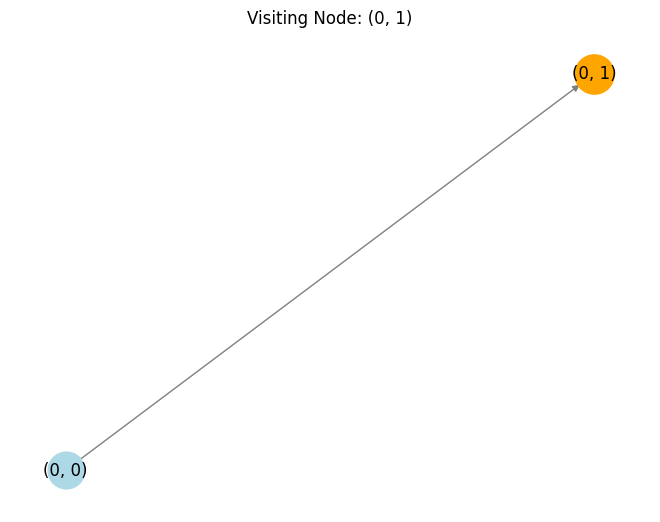

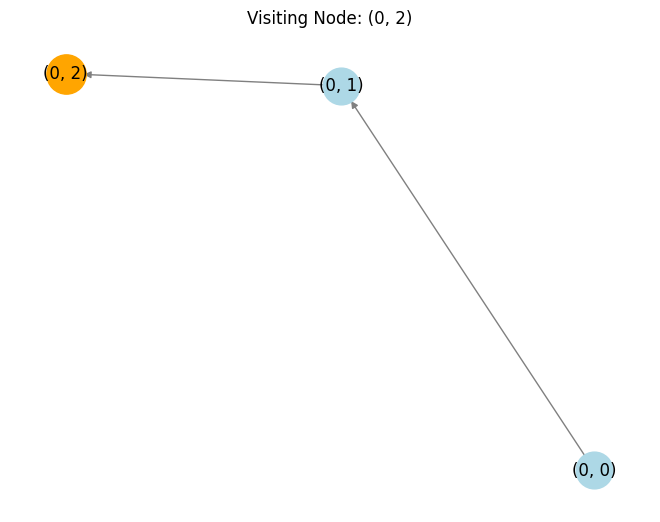

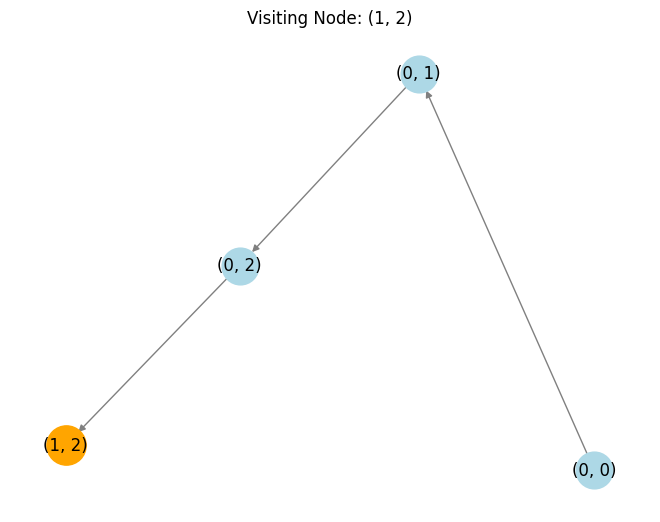

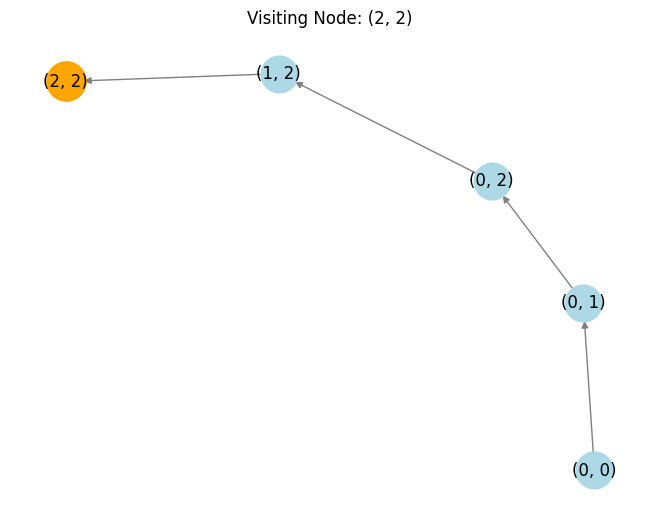

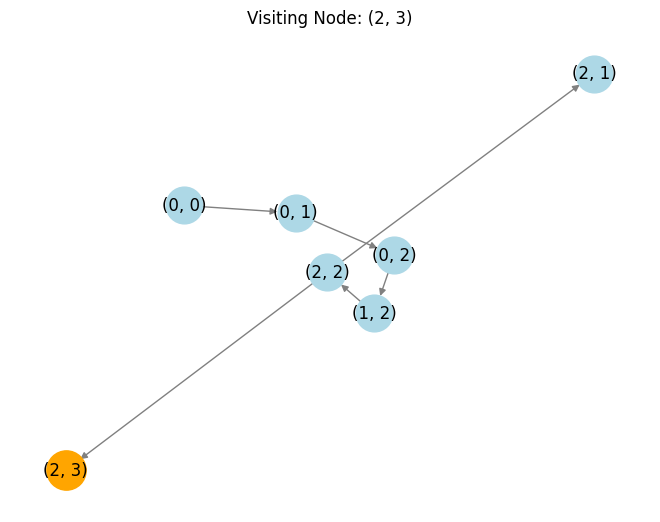

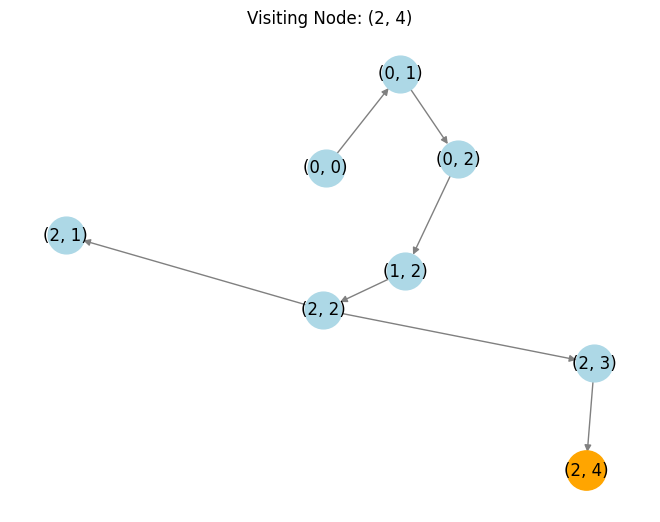

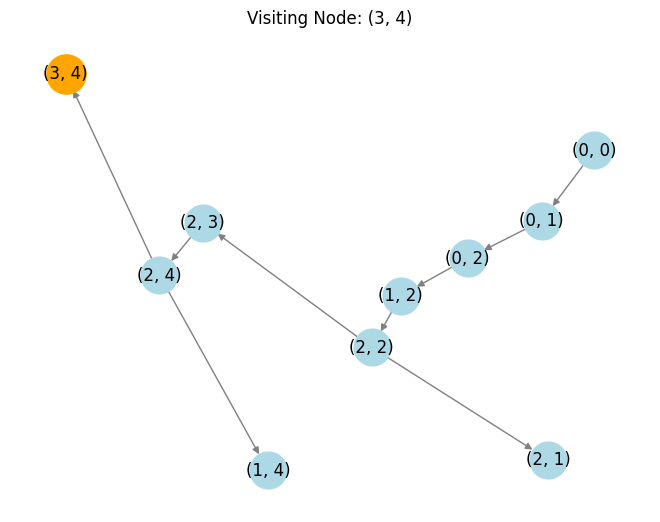

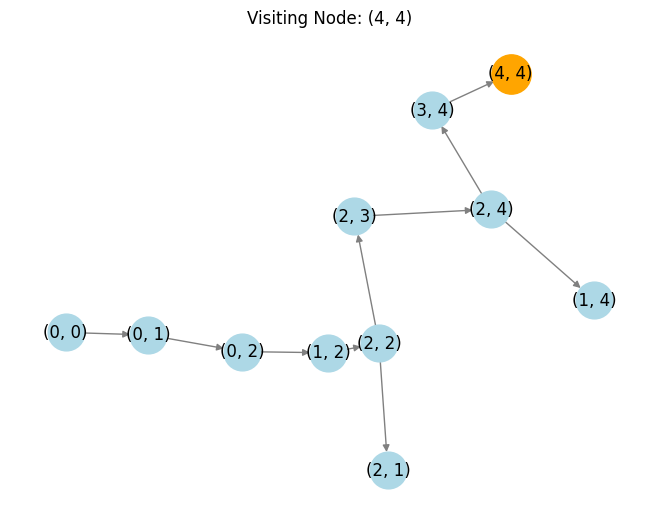

Percorso trovato: [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 3), (2, 4), (3, 4), (4, 4)]


In [27]:
import networkx as nx
import matplotlib.pyplot as plt
import heapq
import numpy as np
import time

def heuristic(a, b):
    """Funzione euristica: distanza di Manhattan."""
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def a_star_search(game_map, start, target, visualize=True, delay=0.5):
    """Esegue l'algoritmo A* con visualizzazione dinamica."""
    open_set = []
    heapq.heappush(open_set, (0, start))

    came_from = {}  # Tiene traccia del percorso
    g_score = {start: 0}
    f_score = {start: heuristic(start, target)}

    G = nx.DiGraph()  # Crea un grafo diretto per la visualizzazione dinamica

    fig, ax = plt.subplots(figsize=(10, 6))
    pos = {}  # Dizionario per le posizioni dei nodi nel grafico

    while open_set:
        _, current = heapq.heappop(open_set)

        if visualize:
            G.add_node(current)
            pos = nx.spring_layout(G)  # Disposizione dinamica dei nodi
            nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700, edge_color='gray')
            nx.draw_networkx_nodes(G, pos, nodelist=[current], node_color='orange', node_size=800)
            plt.title(f"Visiting Node: {current}")
            plt.pause(delay)
            plt.clf()

        if current == target:
            return reconstruct_path(came_from, current)

        for neighbor in get_neighbors(game_map, current):
            tentative_g_score = g_score[current] + 1
            if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = tentative_g_score + heuristic(neighbor, target)
                heapq.heappush(open_set, (f_score[neighbor], neighbor))

                G.add_edge(current, neighbor)  # Aggiunge l'arco al grafo

    return None  # Se non viene trovato un percorso

def get_neighbors(game_map, node):
    """Restituisce i vicini validi di un nodo nella mappa."""
    x, y = node
    neighbors = [(x + dx, y + dy) for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]]
    return [n for n in neighbors if is_valid_position(game_map, n)]

def is_valid_position(game_map, pos):
    """Verifica se la posizione è valida (non un ostacolo)."""
    x, y = pos
    return 0 <= x < game_map.shape[0] and 0 <= y < game_map.shape[1] and game_map[x, y] != 1

def reconstruct_path(came_from, current):
    """Ricostruisce il percorso dalla destinazione alla partenza."""
    path = [current]
    while current in came_from:
        current = came_from[current]
        path.append(current)
    path.reverse()
    return path

# Esempio di utilizzo
if __name__ == "__main__":
    # Mappa di esempio (0 = spazio libero, 1 = ostacolo)
    game_map = np.array([
        [0, 0, 0, 1, 0],
        [1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0]
    ])

    start = (0, 0)
    target = (4, 4)

    path = a_star_search(game_map, start, target, visualize=True)

    if path:
        print("Percorso trovato:", path)
    else:
        print("Nessun percorso trovato.")


In [10]:
from gym import envs

# Ottieni tutti gli ambienti registrati
all_envs = envs.registry.all()

# Filtra quelli che appartengono a MiniHack
minihack_envs = [env.id for env in all_envs if "MiniHack" in env.id]

# Stampa l'elenco delle mappe
for env in sorted(minihack_envs):
    print(env)


MiniHack-Boxoban-Hard-v0
MiniHack-Boxoban-Medium-v0
MiniHack-Boxoban-Unfiltered-v0
MiniHack-ClosedDoor-v0
MiniHack-Corridor-R2-v0
MiniHack-Corridor-R3-v0
MiniHack-Corridor-R5-v0
MiniHack-CorridorBattle-Dark-v0
MiniHack-CorridorBattle-v0
MiniHack-Eat-Distr-v0
MiniHack-Eat-Fixed-v0
MiniHack-Eat-v0
MiniHack-ExploreMaze-Easy-Mapped-v0
MiniHack-ExploreMaze-Easy-v0
MiniHack-ExploreMaze-Hard-Mapped-v0
MiniHack-ExploreMaze-Hard-v0
MiniHack-Freeze-Horn-Full-v0
MiniHack-Freeze-Horn-Restricted-v0
MiniHack-Freeze-Lava-Full-v0
MiniHack-Freeze-Lava-Restricted-v0
MiniHack-Freeze-Random-Full-v0
MiniHack-Freeze-Random-Restricted-v0
MiniHack-Freeze-Wand-Full-v0
MiniHack-Freeze-Wand-Restricted-v0
MiniHack-HideNSeek-Big-v0
MiniHack-HideNSeek-Lava-v0
MiniHack-HideNSeek-Mapped-v0
MiniHack-HideNSeek-v0
MiniHack-KeyRoom-Dark-S15-v0
MiniHack-KeyRoom-Dark-S5-v0
MiniHack-KeyRoom-Fixed-S5-v0
MiniHack-KeyRoom-S15-v0
MiniHack-KeyRoom-S5-v0
MiniHack-Labyrinth-Big-v0
MiniHack-Labyrinth-Small-v0
MiniHack-LavaCross-Ful